🔧 Cell 1 — Install deps (Colab-safe)

In [1]:
!pip -q install --upgrade pip
!pip -q install yfinance pandas_market_calendars --upgrade


🧠 Cell 2 — Imports & versions

In [2]:
import os, sys, platform, warnings, random, json, subprocess, textwrap
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_market_calendars as mcal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, regularizers, backend as K

warnings.filterwarnings("ignore")

print("Python      :", sys.version.split()[0])
print("OS          :", platform.platform())
print("NumPy       :", np.__version__)
print("Pandas      :", pd.__version__)
print("Matplotlib  :", matplotlib.__version__)
print("scikit-learn:", __import__('sklearn').__version__)
print("TensorFlow  :", tf.__version__)
print("yfinance    :", yf.__version__)
print("pandas_market_calendars:", mcal.__version__)


Python      : 3.13.5
OS          : Windows-11-10.0.26100-SP0
NumPy       : 2.3.3
Pandas      : 2.3.2
Matplotlib  : 3.10.6
scikit-learn: 1.7.2
TensorFlow  : 2.20.0
yfinance    : 0.2.65
pandas_market_calendars: 5.1.1


🎲 Cell 3 — Reproducibility & runtime check

In [3]:
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("GPUs:", tf.config.list_physical_devices('GPU'))
try:
    out = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
    print(textwrap.shorten(out.stdout, width=900, placeholder="..."))
except Exception:
    print("nvidia-smi not available (CPU runtime is fine).")


GPUs: []
nvidia-smi not available (CPU runtime is fine).


⚙️ Cell 4 — Project config (AAPL High via prev-Close)

In [4]:
# ===== PIPELINE: AAPL High prediction via log-return to previous Close =====
# Target r_high_t = ln(High_t / Close_{t-1})
# Reconstruct Ĥ_t = Close_{t-1} * exp(r̂_high_t)

TICKER        = "AAPL"
START         = "2000-01-01"
END           = None             # last completed UTC day
TRIM_YEARS    = 10               # keep recent data
LOOKBACK      = 60               # 60–90 typical
CALENDAR      = "XNYS"
N_FUTURE_DEF  = 14
MAX_FUTURE_DAYS = 252

# Where we’ll save the base HIGH model (later step)
HIGH_BASE_DIR = "models/base_aapl_high"
os.makedirs(HIGH_BASE_DIR, exist_ok=True)

print("✅ Config ready for HIGH model:")
print(f"  TICKER     : {TICKER}")
print(f"  LOOKBACK   : {LOOKBACK}")
print(f"  TRIM_YEARS : {TRIM_YEARS}")
print(f"  CALENDAR   : {CALENDAR}")
print(f"  SAVE TO    : {HIGH_BASE_DIR}")
print("Target: r_high_t = ln(High_t / Close_{t-1})  →  Ĥ_t = Close_{t-1} * exp(r̂_high_t)")


✅ Config ready for HIGH model:
  TICKER     : AAPL
  LOOKBACK   : 60
  TRIM_YEARS : 10
  CALENDAR   : XNYS
  SAVE TO    : models/base_aapl_high
Target: r_high_t = ln(High_t / Close_{t-1})  →  Ĥ_t = Close_{t-1} * exp(r̂_high_t)


🧰 Cell 5 — Helpers (tz-safe dates, yfinance fetch, calendar align)

In [5]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_market_calendars as mcal
import time

def _last_completed_utc_day():
    return (pd.Timestamp.utcnow().normalize() - pd.Timedelta(days=1))

def _utc_midnight_naive(ts):
    ts = pd.Timestamp(ts)
    if ts.tzinfo is None or ts.tz is None:
        ts = ts.tz_localize("UTC")
    else:
        ts = ts.tz_convert("UTC")
    return ts.normalize().tz_localize(None)

def _resolve_dates(start=None, end=None):
    s = pd.Timestamp(start) if start else pd.Timestamp("2000-01-01")
    e = pd.Timestamp(end)   if end   else _last_completed_utc_day()
    return _utc_midnight_naive(s), _utc_midnight_naive(e)

def _flatten_columns(cols, ticker_expected=None):
    if isinstance(cols, pd.MultiIndex):
        if cols.nlevels == 2:
            sec = {t for (_, t) in cols}
            if len(sec) == 1 and (ticker_expected is None or list(sec)[0] == ticker_expected):
                flat = [str(f) for (f, _) in cols]
            else:
                flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
        else:
            flat = ["_".join([str(x) for x in tup if x is not None]) for tup in cols]
    else:
        flat = [str(c) for c in cols]
    return [c.strip().title().replace(" ", "_") for c in flat]

def fetch_ohlcv_yf(ticker, start_dt, end_dt, auto_adjust=True, max_retries=3, sleep_sec=1.5):
    start_s, end_s = str(start_dt.date()), str(end_dt.date())
    last_err = None
    for attempt in range(1, max_retries+1):
        try:
            df = yf.download(
                tickers=ticker, start=start_s, end=end_s,
                auto_adjust=auto_adjust, progress=False, threads=True, group_by="column"
            )
            if df is None or df.empty:
                raise ValueError(f"No data for {ticker} in {start_s}→{end_s}")

            df.index = pd.to_datetime(df.index, utc=False)
            if getattr(df.index, "tz", None) is not None:
                df.index = df.index.tz_localize(None)
            df = df.sort_index().loc[~df.index.duplicated(keep="first")]
            df.columns = _flatten_columns(df.columns, ticker_expected=ticker.upper())
            for c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce")
            df = df.dropna(how="all")

            # Align to trading calendar
            cal = mcal.get_calendar(CALENDAR)
            sched = cal.schedule(start_date=start_s, end_date=end_s)
            idx = sched.index
            if getattr(idx, "tz", None) is not None:
                idx = idx.tz_localize(None)
            idx = pd.DatetimeIndex(idx)
            df = df.loc[df.index.intersection(idx)]

            need = {"High", "Close"}
            if not need.issubset(set(df.columns)):
                miss = need - set(df.columns)
                raise ValueError(f"Missing columns: {miss}")
            df = df.dropna(subset=["High", "Close"])
            if not df.index.is_monotonic_increasing:
                df = df.sort_index()
            if df.empty:
                raise ValueError("All rows dropped after cleaning.")
            return df
        except Exception as e:
            last_err = e
            if attempt < max_retries:
                time.sleep(sleep_sec)
            else:
                raise RuntimeError(f"Fetch failed after {max_retries} attempts: {e}") from e


📈 Cell 6 — Download AAPL, trim, compute High log-returns to prev Close

In [6]:
# Resolve window and fetch
START_DT, END_DT = _resolve_dates(START, END)
raw_df = fetch_ohlcv_yf(TICKER, START_DT, END_DT, auto_adjust=True)
print(f"✅ Downloaded {TICKER}: {len(raw_df)} rows | {raw_df.index.min().date()} → {raw_df.index.max().date()}")
print("Columns:", list(raw_df.columns))

# Keep only what we need
hc = raw_df[["High", "Close"]].copy()

# Trim to last TRIM_YEARS
cutoff = hc.index.max() - pd.DateOffset(years=TRIM_YEARS)
hc = hc[hc.index >= cutoff].copy()
print(f"Using last {TRIM_YEARS} years → {len(hc)} rows | {hc.index.min().date()} → {hc.index.max().date()}")

# Build r_high_t = ln(High_t / Close_{t-1})
prev_close = hc["Close"].shift(1)
high_logret = np.log(hc["High"] / prev_close)

high_df = pd.DataFrame({
    "High": hc["High"],
    "Prev_Close": prev_close,
    "HighLogRet": high_logret
}).dropna()

# Guards
TOTAL_MIN_ROWS = LOOKBACK + 200
if len(high_df) < TOTAL_MIN_ROWS:
    raise ValueError(f"Not enough rows after trim/diff: have {len(high_df)}, need ≥ {TOTAL_MIN_ROWS}.")

assert isinstance(high_df.index, pd.DatetimeIndex) and high_df.index.tz is None
assert high_df.index.is_monotonic_increasing
assert np.isfinite(high_df["HighLogRet"]).all()

print("✅ High-return series ready:", high_df.shape)
display(high_df[["Prev_Close","High","HighLogRet"]].tail(5))


✅ Downloaded AAPL: 6463 rows | 2000-01-03 → 2025-09-12
Columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Using last 10 years → 2515 rows | 2015-09-14 → 2025-09-12
✅ High-return series ready: (2514, 3)


,Prev_Close,High,HighLogRet
2025-09-08,239.690002,240.149994,0.001917
2025-09-09,237.880005,238.779999,0.003776
2025-09-10,234.350006,232.419998,-0.008270
2025-09-11,226.789993,230.449997,0.016009
2025-09-12,230.029999,234.509995,0.019288


🪚 Cell 7 — Chronological split + StandardScaler (fit on TRAIN only)

In [7]:
from sklearn.preprocessing import StandardScaler

# 70 / 15 / 15 split (time-ordered)
n = len(high_df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_df = high_df.iloc[:train_end].copy()
val_df   = high_df.iloc[train_end:val_end].copy()
test_df  = high_df.iloc[val_end:].copy()

# Fit scaler ONLY on TRAIN for the standardized HighLogRet
scaler = StandardScaler()
scaler.fit(train_df[["HighLogRet"]])

def _scale(df: pd.DataFrame) -> pd.DataFrame:
    arr = scaler.transform(df[["HighLogRet"]])
    return pd.DataFrame(arr, index=df.index, columns=["HighLogRet"])

train_sc = _scale(train_df)
val_sc   = _scale(val_df)
test_sc  = _scale(test_df)

print(f"Rows → Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("Train range:", train_df.index.min().date(), "→", train_df.index.max().date())
print("Val   range:", val_df.index.min().date(),   "→", val_df.index.max().date())
print("Test  range:", test_df.index.min().date(),  "→", test_df.index.max().date())

print("\nScaler (train only): mean, std =", float(scaler.mean_), float(scaler.scale_))
print("Train scaled mean/std ≈", float(train_sc.mean()), float(train_sc.std()))


Rows → Train: 1759 | Val: 377 | Test: 378
Train range: 2015-09-15 → 2022-09-08
Val   range: 2022-09-09 → 2024-03-11
Test  range: 2024-03-12 → 2025-09-12

Scaler (train only): mean, std = 0.010570667106408499 0.014168285100967229
Train scaled mean/std ≈ 8.07893957657874e-18 1.000284373672747


🧩 Cell 8 — Build LSTM sequences (+ align Prev_Close for reconstruction)

In [8]:
import numpy as np

def create_sequences_std_high(
    data_scaled: pd.DataFrame,
    prev_close_series: pd.Series,
    lookback: int,
    col: str = "HighLogRet",
):
    """
    Build sequences from standardized HighLogRet.
    For each target at time t, we also keep Prev_Close_t so we can reconstruct:
        Ĥ_t = Prev_Close_t * exp(r̂_high_t)
    """
    X, y, pc = [], [], []
    vals = data_scaled[col].values
    prev_vals = prev_close_series.reindex(data_scaled.index).values  # aligned to t

    for i in range(lookback, len(vals)):
        X.append(vals[i - lookback:i].reshape(lookback, 1))
        y.append(vals[i])
        pc.append(prev_vals[i])  # Prev_Close_t

    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)
    pc = np.asarray(pc, dtype=np.float32)

    return X, y, pc

# Sequences for each split
X_train, y_train, pc_train = create_sequences_std_high(
    train_sc, train_df["Prev_Close"], LOOKBACK
)
X_val,   y_val,   pc_val   = create_sequences_std_high(
    val_sc,   val_df["Prev_Close"],   LOOKBACK
)
X_test,  y_test,  pc_test  = create_sequences_std_high(
    test_sc,  test_df["Prev_Close"],  LOOKBACK
)

print("✅ Sequences built.")
print("  Train:", X_train.shape, y_train.shape, pc_train.shape)
print("  Val  :", X_val.shape,   y_val.shape,   pc_val.shape)
print("  Test :", X_test.shape,  y_test.shape,  pc_test.shape)

# Guards
assert X_train.shape[-1] == 1, "Univariate sequences must have 1 feature."
assert not np.isnan(X_train).any() and not np.isnan(y_train).any(), "NaNs in training sequences."
assert np.all(pc_train > 0), "Prev_Close must be positive for reconstruction."


✅ Sequences built.
  Train: (1699, 60, 1) (1699,) (1699,)
  Val  : (317, 60, 1) (317,) (317,)
  Test : (318, 60, 1) (318,) (318,)


🧱 Cell 9 — Build & compile LSTM (for HighLogRet)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers, metrics, regularizers, backend as K
import tensorflow as tf

# Safety: confirm shapes from Step 3
assert X_train.ndim == 3 and X_train.shape[1] == LOOKBACK, "X_train shape mismatch."
N_FEATURES = X_train.shape[2]
print(f"LOOKBACK={LOOKBACK}, N_FEATURES={N_FEATURES} (should be 1)")

# R² (on standardized returns; we'll evaluate price-scale later)
def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1.0 - ss_res / (ss_tot + K.epsilon())

def make_lstm_high_model(
    lookback: int = LOOKBACK,
    n_features: int = N_FEATURES,
    lr: float = 2e-4,
    use_conv_denoiser: bool = True,
    bidirectional: bool = True,
):
    K.clear_session()

    inp = keras.Input(shape=(lookback, n_features), name="seq")

    x = inp
    if use_conv_denoiser:
        # light denoiser on standardized HighLogRet
        x = layers.Conv1D(
            filters=16, kernel_size=3, padding="same",
            activation="swish", kernel_regularizer=regularizers.l2(1e-6)
        )(x)
        x = layers.Dropout(0.10)(x)

    # recurrent stack
    if bidirectional:
        x = layers.Bidirectional(
            layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(1e-6))
        )(x)
    else:
        x = layers.LSTM(64, return_sequences=True, kernel_regularizer=regularizers.l2(1e-6))(x)
    x = layers.Dropout(0.20)(x)
    x = layers.LayerNormalization()(x)

    if bidirectional:
        x = layers.Bidirectional(
            layers.LSTM(32, return_sequences=False, kernel_regularizer=regularizers.l2(1e-6))
        )(x)
    else:
        x = layers.LSTM(32, return_sequences=False, kernel_regularizer=regularizers.l2(1e-6))(x)
    x = layers.Dropout(0.15)(x)

    # dense head
    x = layers.Dense(64, activation="swish")(x)
    x = layers.Dropout(0.10)(x)
    out = layers.Dense(1, name="high_logret_std")(x)  # standardized r_high_t

    model = keras.Model(inp, out, name="lstm_high")

    # robust loss for returns
    loss = keras.losses.Huber(delta=1.0)
    opt  = optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=[metrics.MAE, metrics.RootMeanSquaredError(name="rmse"), r2_metric],
    )
    return model

model = make_lstm_high_model()
model.summary()


LOOKBACK=60, N_FEATURES=1 (should be 1)



Model: "lstm_high"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ seq (InputLayer)                │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 60, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 128)        │        41,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 60, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ high_logret_std (Dense)         │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,233 (340.75 KB)

 Trainable params: 87,233 (340.75 KB)

 Non-trainable params: 0 (0.00 B)

🧪 Cell 10 — Sanity forward pass

In [10]:
# Quick dry-run to verify graph & shapes (no training yet)
y_pred_sample = model.predict(X_train[:2], verbose=0)
print("Pred shape:", y_pred_sample.shape)  # expect (2, 1)
print("✅ Model graph OK. Trainable params:", model.count_params())


Pred shape: (2, 1)
✅ Model graph OK. Trainable params: 87233


🏃 Cell 11 — Train (no saving)

In [11]:
# Step 5 — Train the HIGH model (no saving here)

import numpy as np
from tensorflow import keras

EPOCHS     = 120
BATCH_SIZE = 64

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=18, restore_best_weights=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=8, min_delta=1e-4, min_lr=1e-6, verbose=1
    ),
    keras.callbacks.TerminateOnNaN(),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,           # keep time order
    callbacks=callbacks,
    verbose=1
)

print("✅ Training complete.")
print("  Best val_loss:", float(np.min(history.history["val_loss"])))
print("  Final train_loss:", float(history.history["loss"][-1]))


Epoch 1/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - loss: 0.3574 - mean_absolute_error: 0.6863 - r2_metric: -65.8088 - rmse: 1.0200 - val_loss: 0.2435 - val_mean_absolute_error: 0.5634 - val_r2_metric: -66.3457 - val_rmse: 0.7416 - learning_rate: 2.0000e-04
Epoch 2/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.3533 - mean_absolute_error: 0.6839 - r2_metric: -65.5040 - rmse: 1.0130 - val_loss: 0.2341 - val_mean_absolute_error: 0.5398 - val_r2_metric: -64.0930 - val_rmse: 0.7284 - learning_rate: 2.0000e-04
Epoch 3/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.3436 - mean_absolute_error: 0.6730 - r2_metric: -64.6385 - rmse: 0.9986 - val_loss: 0.2377 - val_mean_absolute_error: 0.5484 - val_r2_metric: -64.6506 - val_rmse: 0.7330 - learning_rate: 2.0000e-04
Epoch 4/120
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.3473 - mean_absolute_error: 0.6774 - r2_metric: -64.7342 - rmse: 1.0057 - val_loss: 0.2350 - val_mean_absolute_error: 0.5420 - val_r2_metric: -64.1051 - val_

✅ Cell 13 — Validation metrics (price) + preview

In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1) Predict standardized HighLogRet on validation sequences
y_pred_std = model.predict(X_val, verbose=0).ravel()
y_true_std = y_val.ravel()

# 2) Inverse-transform to actual High log-returns
y_pred_log = scaler.inverse_transform(y_pred_std.reshape(-1, 1)).ravel()
y_true_log = scaler.inverse_transform(y_true_std.reshape(-1, 1)).ravel()

# 3) Reconstruct next-day HIGH using Prev_Close_t
pred_high = pc_val * np.exp(y_pred_log)
true_high = pc_val * np.exp(y_true_log)

# 4) Metrics — price scale
mae_price  = mean_absolute_error(true_high, pred_high)
rmse_price = mean_squared_error(true_high, pred_high)
mape_price = (np.abs((true_high - pred_high) / np.maximum(1e-8, np.abs(true_high)))).mean() * 100.0
r2_price   = r2_score(true_high, pred_high)

# 5) Optional: “direction” vs previous close (not always informative for High)
da_vs_prev = (np.sign(pred_high - pc_val) == np.sign(true_high - pc_val)).mean() * 100.0

print("📊 Validation — Next-day HIGH (price scale)")
print(f"  MAE :  {mae_price:.4f}")
print(f"  RMSE:  {rmse_price:.4f}")
print(f"  MAPE:  {mape_price:.2f}%")
print(f"  R² accuracy of model:  {r2_price*100:.4f}%")
print(f"  Direction vs prev close: {da_vs_prev:.2f}%")

# 6) Preview last few validation points
val_dates = val_df.index[LOOKBACK:]
preview = pd.DataFrame({
    "prev_close": pc_val[-5:],
    "true_high":  true_high[-5:],
    "pred_high":  pred_high[-5:],
    "abs_error":  np.abs(true_high[-5:] - pred_high[-5:])
}, index=pd.Index(val_dates[-5:], name="date")).round(4)
display(preview)


📊 Validation — Next-day HIGH (price scale)
  MAE :  1.2868
  RMSE:  2.9590
  MAPE:  0.76%
  R² accuracy of model:  99.1229%
  Direction vs prev close: 84.54%


,prev_close,true_high,pred_high,abs_error
date,,,,
2024-03-05,173.851501,170.813400,174.939896,4.1265
2024-03-06,168.906998,170.019104,170.042404,0.0234
2024-03-07,167.914200,169.512695,169.063705,0.4490
2024-03-08,167.794998,172.461594,168.904007,3.5576
2024-03-11,169.512695,173.136703,170.654800,2.4819


📈 Cell 14 — Plot: validation actual vs predicted HIGH

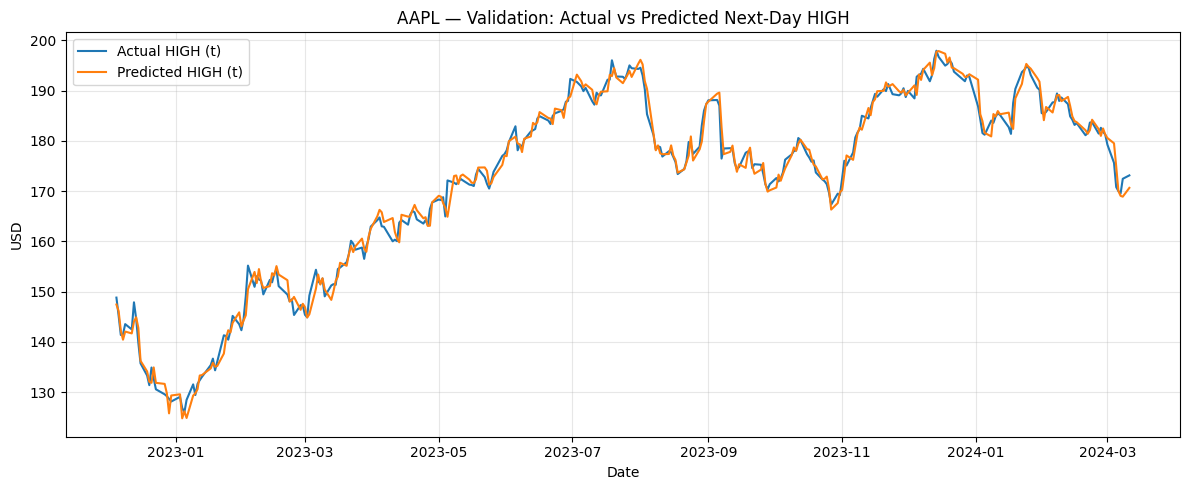

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(val_dates, true_high, label="Actual HIGH (t)")
plt.plot(val_dates, pred_high, label="Predicted HIGH (t)")
plt.title(f"{TICKER} — Validation: Actual vs Predicted Next-Day HIGH")
plt.xlabel("Date"); plt.ylabel("USD")
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


In [17]:
import os, json, joblib
from tensorflow import keras

# Ensure target dir exists (defined earlier as HIGH_BASE_DIR)
os.makedirs(HIGH_BASE_DIR, exist_ok=True)

# 1) Save model (native Keras format)
high_model_path = os.path.join(HIGH_BASE_DIR, "model.keras")
model.save(high_model_path)

# 2) Save scaler (fit on TRAIN HighLogRet)
high_scaler_path = os.path.join(HIGH_BASE_DIR, "scaler.pkl")
joblib.dump(scaler, high_scaler_path)

# 3) Save config (metadata/provenance)
high_cfg = {
    "pipeline": "univariate_high",
    "ticker": "AAPL",
    "lookback": LOOKBACK,
    "trim_years": TRIM_YEARS,
    "calendar": CALENDAR,
    "feature_in": "HighLogRet (standardized)",
    "target": "HighLogRet",
    "reconstruction": "High_t = Prev_Close_t * exp(HighLogRet_t)"
}
high_cfg_path = os.path.join(HIGH_BASE_DIR, "config.json")
with open(high_cfg_path, "w") as f:
    json.dump(high_cfg, f, indent=2)

print("✅ Saved AAPL-High base bundle:")
print("  model :", high_model_path)
print("  scaler:", high_scaler_path)
print("  config:", high_cfg_path)


✅ Saved AAPL-High base bundle:
  model : models/base_aapl_high\model.keras
  scaler: models/base_aapl_high\scaler.pkl
  config: models/base_aapl_high\config.json


In [18]:
from tensorflow import keras
import numpy as np
import joblib, os, json

assert os.path.exists(high_model_path),  "model.keras missing"
assert os.path.exists(high_scaler_path), "scaler.pkl missing"
assert os.path.exists(high_cfg_path),    "config.json missing"

m_chk = keras.models.load_model(high_model_path, compile=False)
s_chk = joblib.load(high_scaler_path)
with open(high_cfg_path, "r") as f:
    cfg_chk = json.load(f)

# Tiny forward pass on a couple of validation samples (standardized)
y_hat_std = m_chk.predict(X_val[:2], verbose=0).ravel()
y_hat_log = s_chk.inverse_transform(y_hat_std.reshape(-1,1)).ravel()
h_hat     = pc_val[:2] * np.exp(y_hat_log)

print("Layers:", len(m_chk.layers), "| Lookback:", cfg_chk.get("lookback"))
print("Sample predicted Highs:", h_hat)
print("✅ Reload OK — AAPL-High bundle is ready.")


Layers: 11 | Lookback: 60
Sample predicted Highs: [147.4485  146.16122]
✅ Reload OK — AAPL-High bundle is ready.


🔢 Cell 17 — Ask N, load High bundle, try to load Close bundle, build prev-Close path

In [20]:
import os, json, joblib
from tensorflow import keras
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal

# --- Ask N ---
try:
    rawN = input(f"Enter FUTURE trading days to forecast for {TICKER} HIGH (1–{MAX_FUTURE_DAYS}) [Enter={N_FUTURE_DEF}]: ").strip()
except EOFError:
    rawN = ""
if rawN == "":
    N_FUTURE = int(N_FUTURE_DEF)
else:
    try:
        n = int(rawN)
        if not (1 <= n <= MAX_FUTURE_DAYS):
            raise ValueError
        N_FUTURE = n
    except Exception:
        print(f"⚠️ Invalid input. Falling back to default {N_FUTURE_DEF}.")
        N_FUTURE = int(N_FUTURE_DEF)

print(f"✅ Forecast horizon (HIGH): {N_FUTURE} trading days")

# --- Ensure HIGH model/scaler are loaded (from Step 7) ---
try:
    _ = model.count_params()
    _ = scaler.mean_
    print("ℹ️ Using in-memory HIGH model & scaler.")
except Exception:
    print("ℹ️ Reloading HIGH model & scaler from disk.")
    high_model_path  = os.path.join(HIGH_BASE_DIR, "model.keras")
    high_scaler_path = os.path.join(HIGH_BASE_DIR, "scaler.pkl")
    assert os.path.exists(high_model_path) and os.path.exists(high_scaler_path), "HIGH bundle missing. Run Step 7."
    model  = keras.models.load_model(high_model_path, compile=False)
    scaler = joblib.load(high_scaler_path)

# --- Try to load CLOSE base bundle to generate prev-close path ---
CLOSE_BASE_DIR = "models/base_aapl"
def try_load_close_bundle():
    mpath = os.path.join(CLOSE_BASE_DIR, "model.keras")
    spath = os.path.join(CLOSE_BASE_DIR, "scaler.pkl")
    cpath = os.path.join(CLOSE_BASE_DIR, "config.json")
    if not (os.path.exists(mpath) and os.path.exists(spath)):
        return None, None, None
    try:
        cm = keras.models.load_model(mpath, custom_objects={"r2_metric": r2_metric})
        cs = joblib.load(spath)
        cc = json.load(open(cpath)) if os.path.exists(cpath) else {}
        return cm, cs, cc
    except Exception:
        return None, None, None

close_model, close_scaler, close_cfg = try_load_close_bundle()
if close_model is None:
    print("ℹ️ Close base bundle not found — will use fallback prev-close path (drift proxy).")
else:
    print("✅ Close base bundle loaded for prev-close path.")
    CLOSE_LOOKBACK = int(close_cfg.get("lookback", LOOKBACK)) if isinstance(close_cfg, dict) else LOOKBACK
    if CLOSE_LOOKBACK != LOOKBACK:
        print(f"ℹ️ Close LOOKBACK={CLOSE_LOOKBACK} differs from High LOOKBACK={LOOKBACK}. Proceeding anyway.")

# --- Calendar helper ---
def future_trading_days(last_date: pd.Timestamp, n: int) -> pd.DatetimeIndex:
    cal = mcal.get_calendar(CALENDAR)
    start_d = (last_date + pd.Timedelta(days=1)).date()
    end_d   = (last_date + pd.DateOffset(days=max(10, n*3))).date()
    sched = cal.schedule(start_date=start_d, end_date=end_d)
    idx = sched.index
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    idx = pd.DatetimeIndex(idx)[:n]
    if len(idx) < n: raise ValueError("Not enough future trading days.")
    return idx

# --- Build prev-close path via Close model (preferred) or fallback drift proxy ---
def build_prev_close_path_via_close_model(n_steps: int):
    if close_model is None: return None
    close_series = hc["Close"].copy()            # trimmed Close from Cell 6
    ret_close = pd.DataFrame({"LogRet": np.log(close_series).diff()}).dropna()
    std_close = pd.DataFrame(
        close_scaler.transform(ret_close[["LogRet"]]),
        index=ret_close.index, columns=["LogRet"]
    )
    L = CLOSE_LOOKBACK
    if len(std_close) < L: return None
    window = std_close.values[-L:].astype(np.float32).reshape(L, 1)
    last_close = float(close_series.iloc[-1])

    preds_close, cur, prev = [], window.copy(), last_close
    for _ in range(n_steps):
        y_std = float(close_model.predict(cur.reshape(1, L, 1), verbose=0).ravel()[0])
        y_log = float(close_scaler.inverse_transform([[y_std]])[0, 0])
        nxt   = prev * np.exp(y_log)
        preds_close.append(nxt)
        cur = np.vstack([cur[1:], [[y_std]]]); prev = nxt

    prev_closes = np.empty(n_steps, dtype=np.float32)
    prev_closes[0] = last_close
    if n_steps > 1: prev_closes[1:] = np.asarray(preds_close[:-1], dtype=np.float32)
    return prev_closes

def build_prev_close_path_fallback(n_steps: int):
    """Drift proxy: use recent median Close log-return to evolve prev-close."""
    close_series = hc["Close"].copy()
    lr = np.log(close_series).diff().dropna()
    if len(lr) == 0:
        return np.full(n_steps, float(close_series.iloc[-1]), dtype=np.float32)
    drift = float(np.median(lr.tail(120)))  # robust central tendency
    prev = float(close_series.iloc[-1])
    path = np.empty(n_steps, dtype=np.float32)
    for i in range(n_steps):
        if i == 0:
            path[i] = prev
        else:
            prev = prev * np.exp(drift)
            path[i] = prev
    return path

prev_close_path = build_prev_close_path_via_close_model(N_FUTURE)
if prev_close_path is not None:
    print("✅ Prev-close path obtained from Close model.")
else:
    prev_close_path = build_prev_close_path_fallback(N_FUTURE)
    print("⚠️ Using fallback prev-close path (drift proxy).")


✅ Forecast horizon (HIGH): 30 trading days
ℹ️ Using in-memory HIGH model & scaler.
✅ Close base bundle loaded for prev-close path.
ℹ️ Close LOOKBACK=90 differs from High LOOKBACK=60. Proceeding anyway.
✅ Prev-close path obtained from Close model.


🔮 Cell 18 — Rollout N-day High forecast (recursive) + plot

✅ HIGH forecast ready:


,prev_close_used,pred_high_logret,pred_high
date,,,
2025-09-15,234.070007,0.011911,236.874617
2025-09-16,233.157654,0.011512,235.857365
2025-09-17,231.853394,0.010935,234.402733
2025-09-18,231.429062,0.011040,233.998136
2025-09-19,231.482651,0.010805,233.997470


,prev_close_used,pred_high_logret,pred_high
date,,,
2025-10-20,219.299576,0.011104,221.748313
2025-10-21,220.287796,0.011109,222.748549
2025-10-22,220.967789,0.011143,223.443724
2025-10-23,221.508743,0.011130,223.988012
2025-10-24,221.805679,0.011228,224.310096


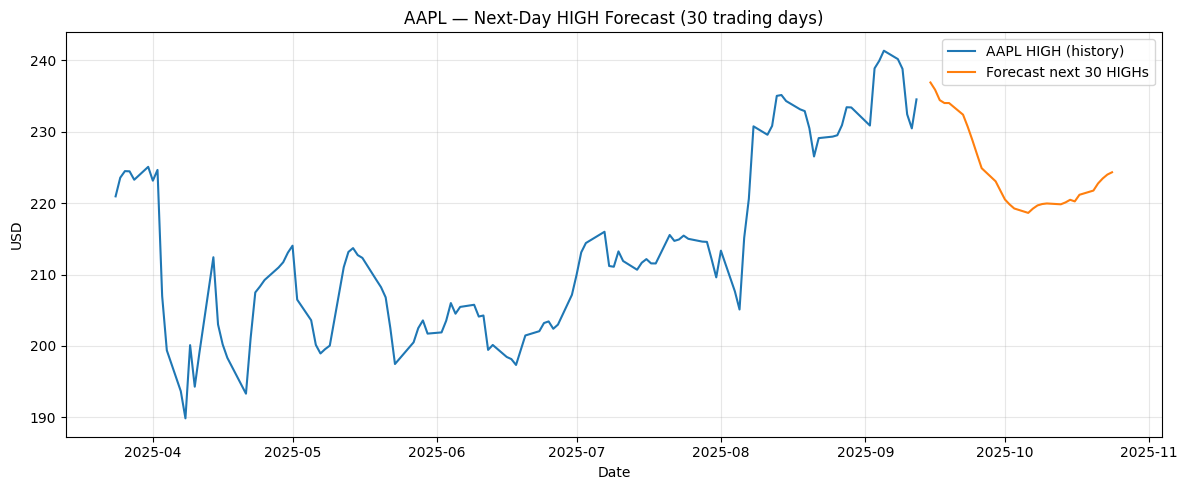

In [21]:
# Seed window for HIGH = last LOOKBACK standardized HighLogRet values
combined_std = pd.concat([train_sc["HighLogRet"], val_sc["HighLogRet"], test_sc["HighLogRet"]]).sort_index()
assert len(combined_std) >= LOOKBACK, "Not enough history to seed."
seed_window = combined_std.values[-LOOKBACK:].astype(np.float32).reshape(LOOKBACK, 1)

# Future dates
future_idx = future_trading_days(high_df.index.max(), N_FUTURE)

# Recursive rollout
pred_std, pred_log, pred_high_path, prev_used = [], [], [], []
cur = seed_window.copy()

for k in range(N_FUTURE):
    prev_for_step = float(prev_close_path[k])   # Close_{t-1} used for High reconstruction
    y_std = float(model.predict(cur.reshape(1, LOOKBACK, 1), verbose=0).ravel()[0])
    y_log = float(scaler.inverse_transform([[y_std]])[0, 0])
    h_hat = prev_for_step * np.exp(y_log)

    pred_std.append(y_std); pred_log.append(y_log); pred_high_path.append(h_hat); prev_used.append(prev_for_step)
    # slide seed with predicted standardized HighLogRet
    cur = np.vstack([cur[1:], [[y_std]]])

forecast_high_df = pd.DataFrame({
    "prev_close_used": prev_used,
    "pred_high_logret": pred_log,
    "pred_high": pred_high_path,
}, index=future_idx)
forecast_high_df.index.name = "date"

print("✅ HIGH forecast ready:")
display(forecast_high_df.head()); display(forecast_high_df.tail())

# Plot last 120 Highs + forecast
hist_days = 120
histH = hc.tail(hist_days).copy()
plt.figure(figsize=(12,5))
plt.plot(histH.index, histH["High"], label=f"{TICKER} HIGH (history)")
plt.plot(forecast_high_df.index, forecast_high_df["pred_high"], label=f"Forecast next {N_FUTURE} HIGHs")
plt.title(f"{TICKER} — Next-Day HIGH Forecast ({N_FUTURE} trading days)")
plt.xlabel("Date"); plt.ylabel("USD"); plt.grid(True, alpha=.3); plt.legend(); plt.tight_layout(); plt.show()
